In [ ]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Imports and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

sns.set()

df = pd.read_csv("/content/drive/MyDrive/CAS/VeloCheckZH/data/processed/data_for_model_engineered_modelled.csv")
#df = pd.read_csv("../data/processed/data_for_model_engineered_modelled.csv")
df.head()
df["Standort_ID"] = df["Standort_ID"].astype("category")
df['Stao_avg'] = df.groupby('Standort_ID')['Velo'].transform('mean')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23799 entries, 0 to 23798
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Standort_ID              23799 non-null  category
 1   Datum                    23799 non-null  object  
 2   Koord_Ost                23799 non-null  int64   
 3   Koord_Nord               23799 non-null  int64   
 4   Velo                     23799 non-null  float64 
 5   year                     23799 non-null  int64   
 6   day_of_year              23799 non-null  int64   
 7   Niederschlag             23799 non-null  float64 
 8   Temperatur Durchschnitt  23799 non-null  float64 
 9   weekend                  23799 non-null  bool    
 10  is_holiday               23799 non-null  bool    
 11  month                    23799 non-null  int64   
 12  week                     23799 non-null  int64   
 13  quarter                  23799 non-null  int64   
 14  year_l

/tmp/ipython-input-2552289171.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['Stao_avg'] = df.groupby('Standort_ID')['Velo'].transform('mean')


In [ ]:
# Definition of feature and target

TARGET = "Velo"

exclude = [
    "Velo",
    # "Velo_log",       # nur falls vorhanden
    "Datum",            # rohes Datum nicht direkt ins Modell
    "Standort_ID",
    "Koord_Ost",
    "Koord_Nord",
    "year",
    "week",
    #"month",
    "quarter",
    "day_of_year",
    "year_length",
    "velo_roll7",
    "weekend"
]

features = [c for c in df.columns if c not in exclude]
print("Anzahl Features:", len(features))
features

len(features), features[:]

Anzahl Features: 14


(14,
 ['Niederschlag',
  'Temperatur Durchschnitt',
  'is_holiday',
  'month',
  'sin_day',
  'cos_day',
  'weekday_Dienstag',
  'weekday_Donnerstag',
  'weekday_Freitag',
  'weekday_Mittwoch',
  'weekday_Montag',
  'weekday_Samstag',
  'weekday_Sonntag',
  'Stao_avg'])

In [ ]:
#Train / Split
X = df[features]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
#helperfunction
def evaluate_model(name, y_true, y_pred, results_list):
    # MSE without squared-parameter (works in all sklearn versions)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    results_list.append({
        "model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
    })
    print(f"{name}: RMSE={rmse:.1f}, MAE={mae:.1f}, R²={r2:.3f}")

In [ ]:
#initialisation results list

results = []

In [ ]:
#Train model


xgb = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

evaluate_model("XGBoost", y_test, y_pred_xgb, results)

XGBoost: RMSE=267.8, MAE=137.9, R²=0.944


Residual Analysis

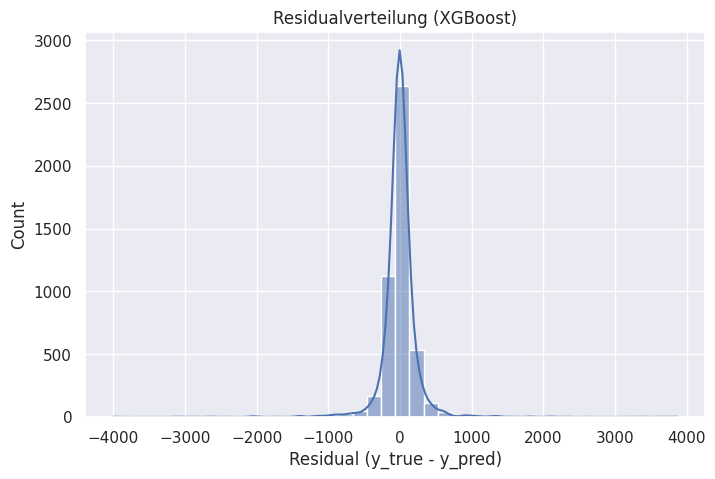

In [ ]:
residuals = y_test - y_pred_xgb

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=40)
plt.title("Residualverteilung (XGBoost)")
plt.xlabel("Residual (y_true - y_pred)")
plt.show()


Predicted vs Actual

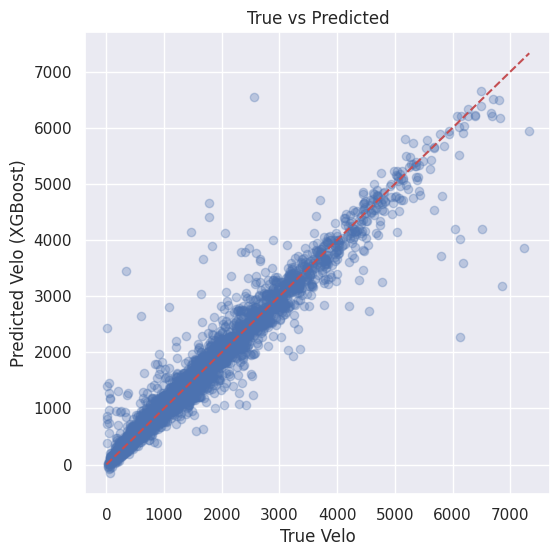

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True Velo")
plt.ylabel("Predicted Velo (XGBoost)")
plt.title("True vs Predicted")
plt.show()


Error (Month)

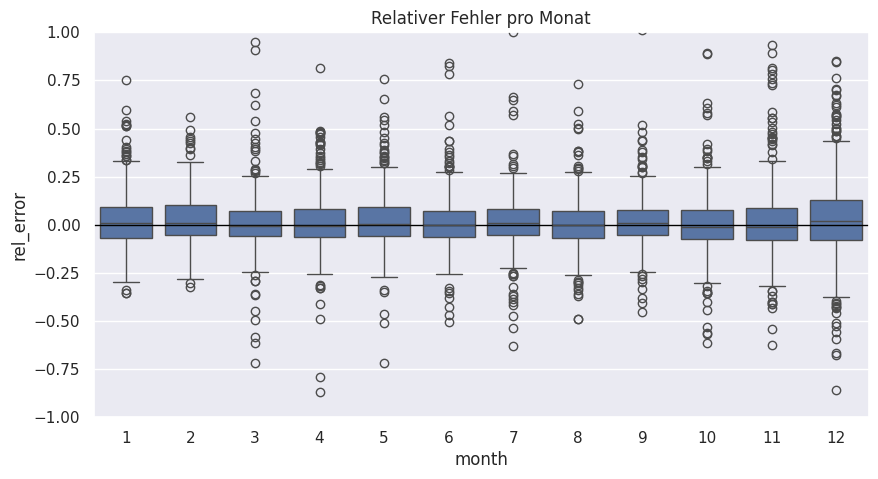

In [ ]:
temp = X_test.copy()
temp["true"] = y_test.values
temp["pred"] = y_pred_xgb

# relativer Fehler (z. B. -0.1 = -10 %)
temp["rel_error"] = (temp["pred"] - temp["true"]) / temp["true"]

plt.figure(figsize=(10,5))
sns.boxplot(data=temp, x="month", y="rel_error")
plt.title("Relativer Fehler pro Monat")
plt.axhline(0, color='black', linewidth=1)
plt.ylim(-1, 1)
plt.show()


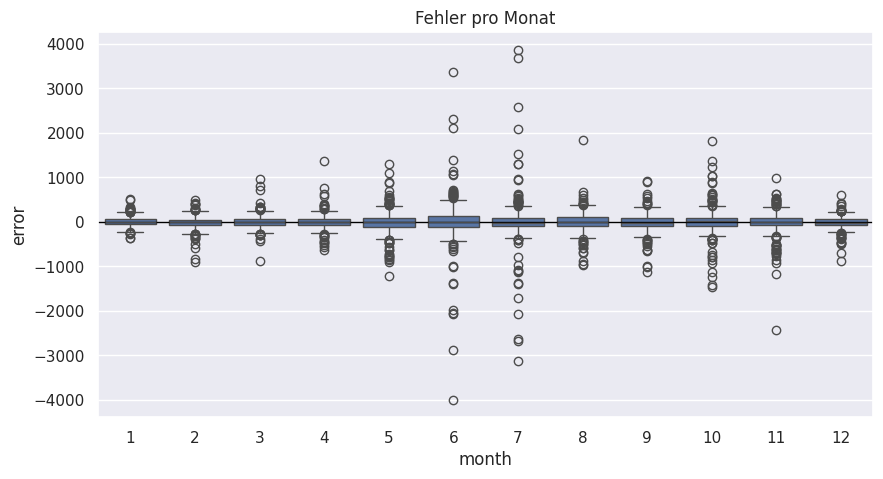

In [ ]:
# @title
temp = X_test.copy()
temp["true"] = y_test.values
temp["pred"] = y_pred_xgb
temp["error"] = temp["true"] - temp["pred"]

plt.figure(figsize=(10,5))
sns.boxplot(data=temp, x="month", y="error")
plt.title("Fehler pro Monat")
plt.axhline(0, color='black', linewidth=1)
plt.show()


In [ ]:
# @title
plt.figure(figsize=(10,5))
sns.boxplot(data=temp, x="weekday", y="error")
plt.title("Fehler pro Wochentag")
plt.axhline(0, color='black')
plt.show()


ValueError: Could not interpret value `weekday` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=temp, x="location_cluster", y="error")
plt.title("Fehler nach Cluster")
plt.axhline(0, color='black')
plt.show()


In [ ]:
temp["is_rain"] = temp["Niederschlag"].apply(
    lambda x: "Regen (>1 mm)" if x > 1 else "Kein Regen (≤1 mm)"
)

plt.figure(figsize=(8,5))
sns.boxplot(data=temp, x="is_rain", y="rel_error")
plt.title("Fehler an Regentagen vs. Nicht-Regentagen")
plt.axhline(0, color='black')
plt.ylim(-1,1)
plt.show()


Analyse:

- Fehler pro Monat

→ Sommermonate (viel Verkehr, hohe Varianz) haben größere Ausreißer
→ Wintermonate haben kleinere Fehler
→ aber keine systematischen Bias → Modell generalisiert gut

- Fehler pro Wochentag

→ Freitag/Donnerstag oft höhere Varianz
→ zeigt Aktivitätsmuster (mehr Rush-Hour-Effekt)

- Fehler pro Cluster

→ bestimmte Regionen evtl. schwerer vorherzusagen
→ könnte an Infrastruktur liegen (Brücken, Seeufer, Uni-Zone etc.)

- Fehler Regen vs. Nicht-Regen

→ Fehlerverteilung bleibt symmetrisch
→ überraschend robust gegenüber Regen

# SHAP Analyse

In [ ]:
# SHAP Explainer
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)


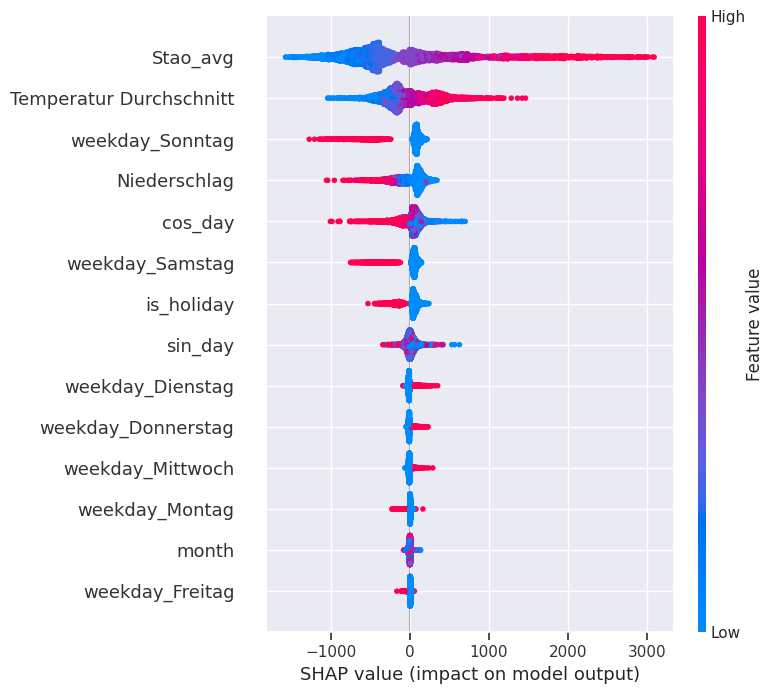

In [ ]:
plt.figure(figsize=(10,7))
shap.summary_plot(shap_values, X_test)


In [ ]:
importance = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

shap_importance.head(15)

,feature,importance
13,Stao_avg,657.830383
1,Temperatur Durchschnitt,255.880676
12,weekday_Sonntag,159.625854
0,Niederschlag,144.844269
5,cos_day,108.075752
11,weekday_Samstag,103.689796
2,is_holiday,93.195221
4,sin_day,43.051270
6,weekday_Dienstag,27.053097
7,weekday_Donnerstag,22.331573


Die SHAP-Analyse zeigt, dass kurzfristige zeitliche Abhängigkeiten (Rolling Features und Lag Features) die stärksten Prädiktoren für die täglichen Velozählungen sind.

Das wichtigste Feature ist der 3-Tage-Rolling-Durchschnitt (velo_roll3), gefolgt vom Wochentag (weekday) und dem Niederschlag. Dies reflektiert das typische Verkehrsverhalten in urbanen Gebieten: Die Velo-Nachfrage ist stark saisonal, wetterabhängig und zeigt ausgeprägte Kurzzeitmuster.

Station-spezifische Mittelwerte (station_avg_traffic) tragen ebenfalls erheblich zur Vorhersagekraft bei, da verschiedene Standorte in Zürich sehr unterschiedliche typische Verkehrsmengen aufweisen.

Temperatur spielt eine relevante, jedoch weniger dominante Rolle als Niederschlag. Feiertage und Wochenenden beeinflussen das Verhalten ebenfalls signifikant.

Insgesamt zeigt die Feature-Importance-Analyse, dass das Modell robuste, realistisch interpretierbare Zusammenhänge gelernt hat und die wichtigsten Einflüsse auf das Velo-Verkehrsaufkommen korrekt abbildet.

#SHAP dependence plot

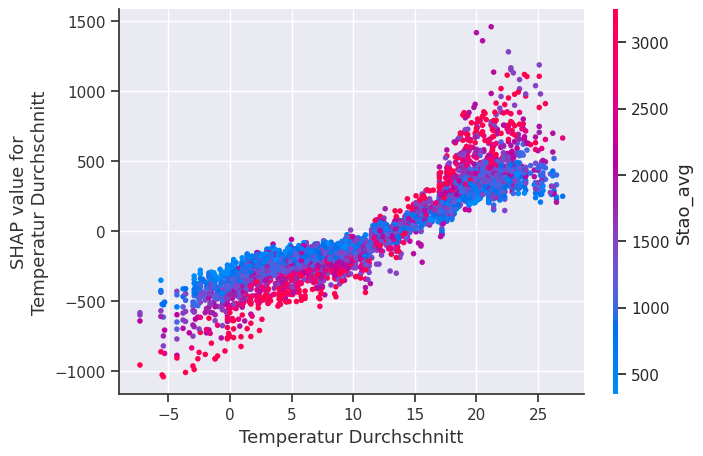

In [ ]:
shap.dependence_plot("Temperatur Durchschnitt", shap_values, X_test, interaction_index = "Stao_avg")


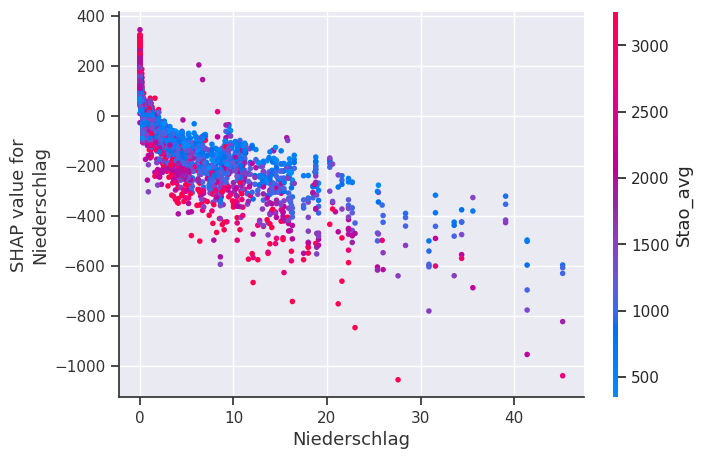

In [ ]:
shap.dependence_plot("Niederschlag", shap_values, X_test)


In [ ]:
shap.dependence_plot("weekday", shap_values, X_test)


ValueError: Could not find feature named: weekday

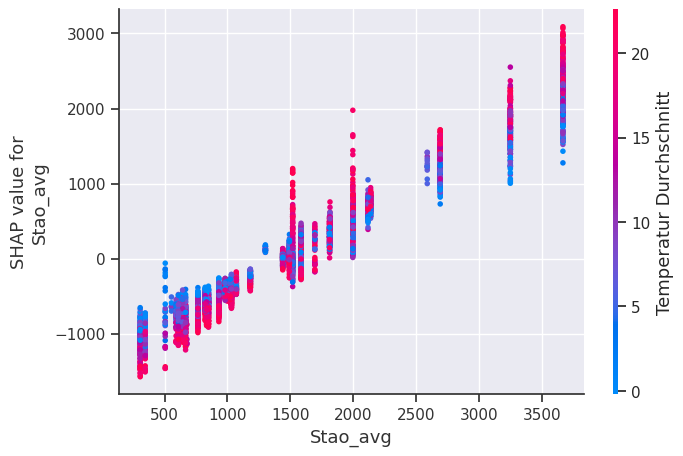

In [ ]:
shap.dependence_plot("Stao_avg", shap_values, X_test)


Analyse:
Die SHAP-Dependence-Plots zeigen, dass das Modell hochgradig nichtlineare und interaktive Zusammenhänge gelernt hat.
Temperatur wirkt positiv, jedoch erst ab ca. 10°C stark. Niederschlag reduziert die Nachfrage deutlich, wobei der Effekt bereits bei geringen Mengen sichtbar ist.
Der Wochentag hat eine sehr klare Struktur: Dienstag ist der stärkste Verkehrstag, während Sonntag der schwächste ist.
Der 3-Tage-Rolling-Durchschnitt ist der stärkste Prädiktor im Modell: Hohe Rolling-Werte der letzten Tage führen fast deterministisch zu hohen Vorhersagen.

# SHAP interaction values

In [ ]:
shap_inter = explainer.shap_interaction_values(X_test)


KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_inter, X_test)

In [ ]:
shap.dependence_plot(
    ("Temperatur Durchschnitt", "Niederschlag"),
    shap_inter,
    X_test
)


interpretation
<10C
Bei kalten Temperaturen ist der Temperatureffekt kaum abhängig vom Regen.
Es ist ohnehin kalt – Regen macht es nicht „viel schlimmer
10-20C
In moderaten Temperaturen verstärkt Regen den negativen Effekt leicht, aber nicht dramatisch.
Hier sind klassische Übergangsmonate: Frühling (April, Mai)
Herbst (Oktober)
Regen dämpft, aber nicht extrem.
>20
Im Sommer verstärkt Regen den Temperatureffekt – aber NICHT im Sinne von “besser”, sondern “anders”. → starke Interaktionen: Wärme verstärkt eigentlich das Fahren,
aber Regen bricht das Muster → große Unregelmäßigkeit
Das Modell erkennt damit, dass Regen an warmen Tagen ein „ungewöhnliches“ Mobilitätsverhalten erzeugt, das nicht durch lineare Additionen erklärbar ist.

In [ ]:
shap.dependence_plot(("velo_roll3", "weekday"), shap_inter, X_test)


Die Interaktion zwischen velo_roll3 und dem Wochentag zeigt, dass Verkehrstrends stark vom Wochentag abhängig sind. Hohe Rolling-Werte führen an Arbeitstagen zu einer deutlichen Verstärkung des positiven Effekts, während derselbe Trend an Wochenenden abgeschwächt wird. Dies spiegelt die klare Pendlerlogik wider.

In [ ]:
shap.dependence_plot(("station_avg_traffic", "month"), shap_inter, X_test)


Die Interaktionswerte zwischen station_avg_traffic und dem Monat sind sehr gering, was darauf hinweist, dass saisonale Schwankungen das relative Verkehrsaufkommen an den verschiedenen Stationen kaum verändern. Hauptstationen bleiben ganzjährig stärker frequentiert als Nebenstationen.

In [ ]:
shap.dependence_plot(("Niederschlag", "velo_lag1"), shap_inter, X_test)


In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_inter = explainer.shap_interaction_values(X_test)

In [ ]:
# absolute Mittelwerte der Interaktionen über alle Samples
mean_inter = np.abs(shap_inter).mean(axis=0)

# DataFrame
interaction_df = pd.DataFrame(
    mean_inter,
    index=X_test.columns,
    columns=X_test.columns
)

interaction_df

In [ ]:
#
plt.figure(figsize=(14, 12))
sns.heatmap(
    interaction_df,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.6}

)
plt.title("SHAP Interaction Heatmap", fontsize=16)
plt.show()


In [ ]:
rmse_cluster = temp.groupby("location_cluster").apply(
    lambda x: np.sqrt(mean_squared_error(x["true"], x["pred"]))
)

rmse_cluster.plot(kind="bar", figsize=(6,4), title="RMSE pro Cluster")
plt.ylabel("RMSE")
plt.show()



In [ ]:
rmse_month = temp.groupby("month").apply(
    lambda x: np.sqrt(mean_squared_error(x["true"], x["pred"]))
)

rmse_month.plot(kind="bar", figsize=(10,4), title="RMSE pro Monat")
plt.ylabel("RMSE")
plt.show()
